# 01 - Feature Engineering

This notebook demonstrates how to:

- Load OHLCV data from `data/`
- Build microstructure / technical / volume-based features
- Inspect feature distributions and correlations

Run the cells top-to-bottom; adapt the data path and parameters for your own assets.



In [4]:
import sys
from pathlib import Path

ROOT = Path("..").resolve()
print("ROOT:", ROOT, "exists?", ROOT.exists())
print("ROOT/research exists?", (ROOT / "research").exists())

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

ROOT: /home/giorgos/Desktop/AlphaFactory exists? True
ROOT/research exists? True


In [10]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from research.common import load_ohlcv_csv, BarConfig
from research.feature_engineering import FeatureConfig, build_features

DATA_PATH = pathlib.Path("../data/equities/AAPL.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Please drop an OHLCV CSV at {DATA_PATH}")

raw = load_ohlcv_csv(str(DATA_PATH))
raw.head()


,timestamp,open,high,low,close,volume
0,2015-01-02,24.69423503534699,24.70532029541843,23.79860048379208,24.237550735473633,212818400
1,2015-01-05,24.006990190147395,24.0867993234754,23.368518814896508,23.554738998413086,257142000
2,2015-01-06,23.61903255400942,23.816338020280458,23.19560061965636,23.55695915222168,263188400
3,2015-01-07,23.76535220011818,23.98704392471396,23.65450633782029,23.887283325195312,160423600
4,2015-01-08,24.21537773680298,24.862716897095112,24.097879750947854,24.805076599121094,237458000


In [11]:
raw = load_ohlcv_csv(str(DATA_PATH))

# Ensure numeric types
for col in ["open", "high", "low", "close", "volume"]:
    raw[col] = pd.to_numeric(raw[col], errors="coerce")

raw = raw.dropna(subset=["open", "high", "low", "close", "volume"]).reset_index(drop=True)
raw.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume              float64
dtype: object

In [12]:
bar_cfg = BarConfig(lookback_window=128, prediction_horizon=5)
feat_cfg = FeatureConfig(bar=bar_cfg)

X, y, feature_cols = build_features(raw, feat_cfg)

X.shape, y.shape, feature_cols[:10]


((2554, 128, 9),
 (2554,),
 ['ret_1',
  'log_ret_1',
  'vol_20',
  'vol_60',
  'vol_chg',
  'vol_zscore_20',
  'vol_roll_sum_20',
  'high_low_spread',
  'close_pos_in_bar'])

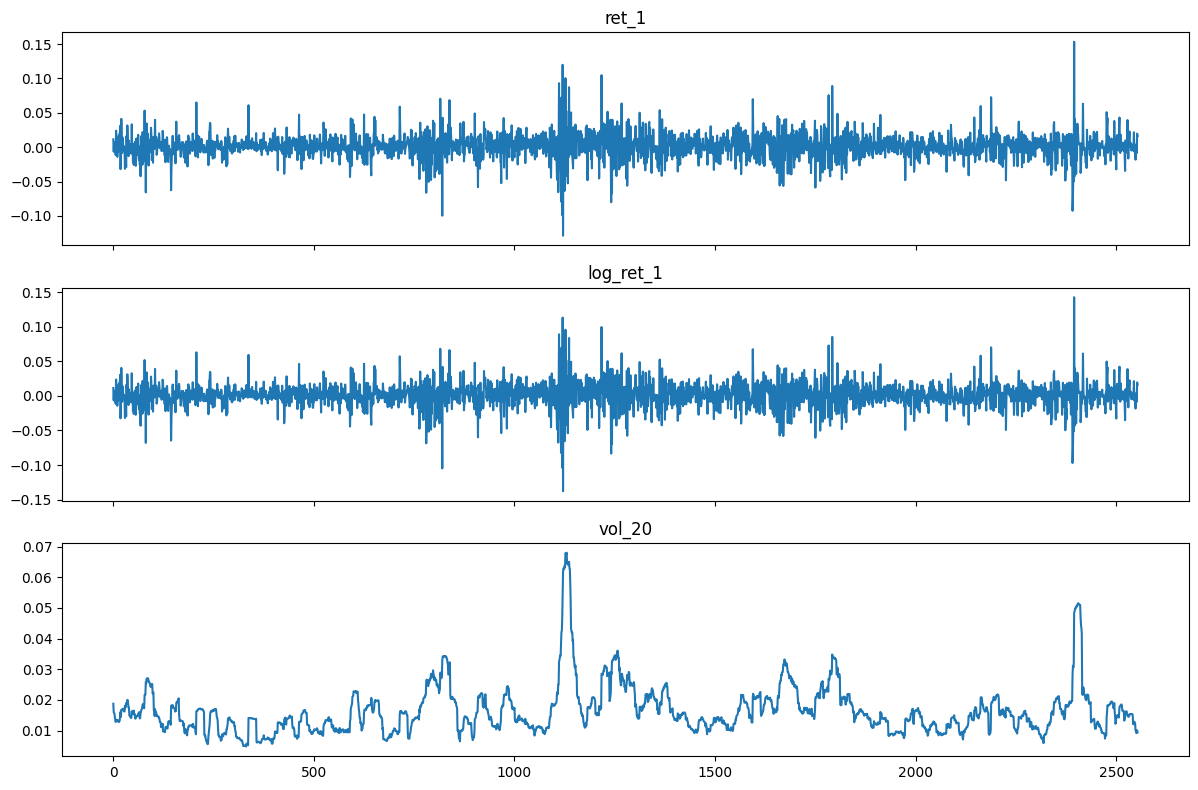

In [13]:
# Plot a few example features over time for intuition

feat_df = pd.DataFrame(
    X[:, -1, :],  # last step in each window
    columns=feature_cols,
)

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for ax, col in zip(axes, feature_cols[:3]):
    ax.plot(feat_df[col].values)
    ax.set_title(col)
plt.tight_layout()
plt.show()


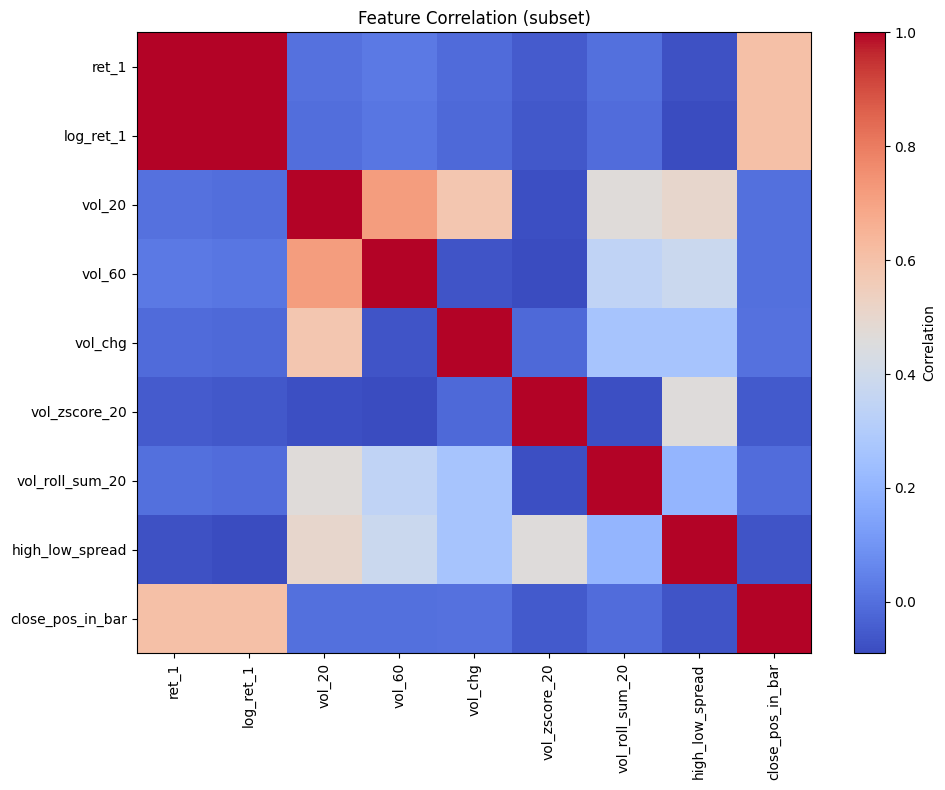

In [14]:
# Simple correlation heatmap of a subset of features

corr = feat_df[feature_cols[:15]].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation (subset)")
plt.tight_layout()
plt.show()
